# lab 7 
Bruce Cai

### Question 9
This question uses the variables dis (the weighted mean of distances
to fve Boston employment centers) and nox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat
dis as the predictor and nox as the response.

(a) Use the poly() function from the ISLP.models module to ft a
cubic polynomial regression to predict nox using dis. Report the
regression output, and plot the resulting data and polynomial
fts.

In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from ISLP.models import bs, ns
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

In [18]:
data = load_data("Boston")
data.head(3)
x = data["dis"]
y = data["nox"]
poly_dis = MS([poly('dis', degree=3)]).fit(data)
M = sm.OLS(y, poly_dis.transform(data)).fit()
print(summarize(M))


                          coef  std err        t  P>|t|
intercept               0.5547    0.003  201.021    0.0
poly(dis, degree=3)[0] -2.0031    0.062  -32.271    0.0
poly(dis, degree=3)[1]  0.8563    0.062   13.796    0.0
poly(dis, degree=3)[2] -0.3180    0.062   -5.124    0.0


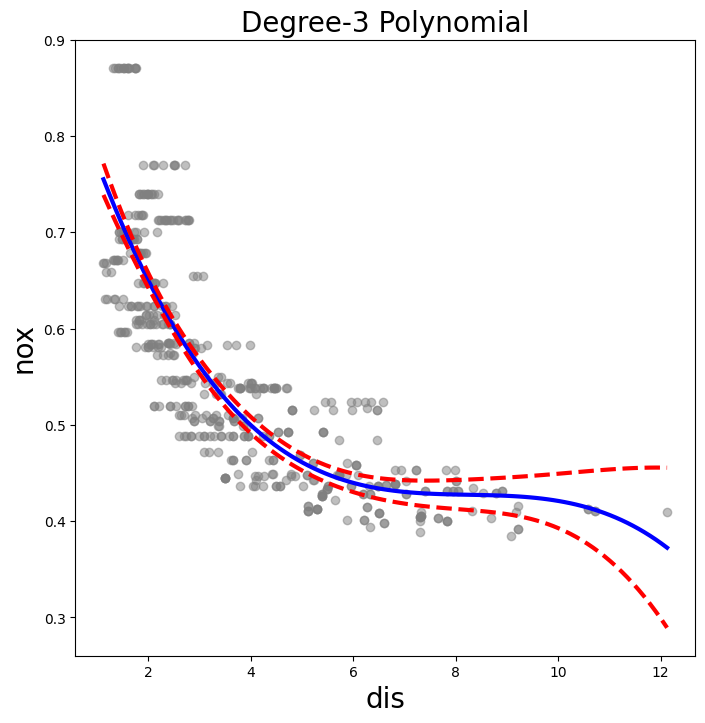

In [27]:
x_grid = np.linspace(x.min(),
                       x.max(),
                       100)
x_df = pd.DataFrame({'dis': x_grid})
def plot_dis_fit(x_df, 
                  basis,
                  title):

    X = basis.transform(data)
    Xnew = basis.transform(x_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(x,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(x_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);
    return ax
plot_dis_fit(x_df, 
              poly_dis,
              'Degree-3 Polynomial');

(b) Plot the polynomial fts for a range of diferent polynomial
degrees (say, from 1 to 10), and report the associated residual
sum of squares.

In [25]:
models = [MS([poly('dis', degree=d)]) 
          for d in range(1, 11)]
Xs = [model.fit_transform(data) for model in models]
print(anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])["ssr"])

0    2.768563
1    2.035262
2    1.934107
3    1.932981
4    1.915290
5    1.878257
6    1.849484
7    1.835630
8    1.833331
9    1.832171
Name: ssr, dtype: float64


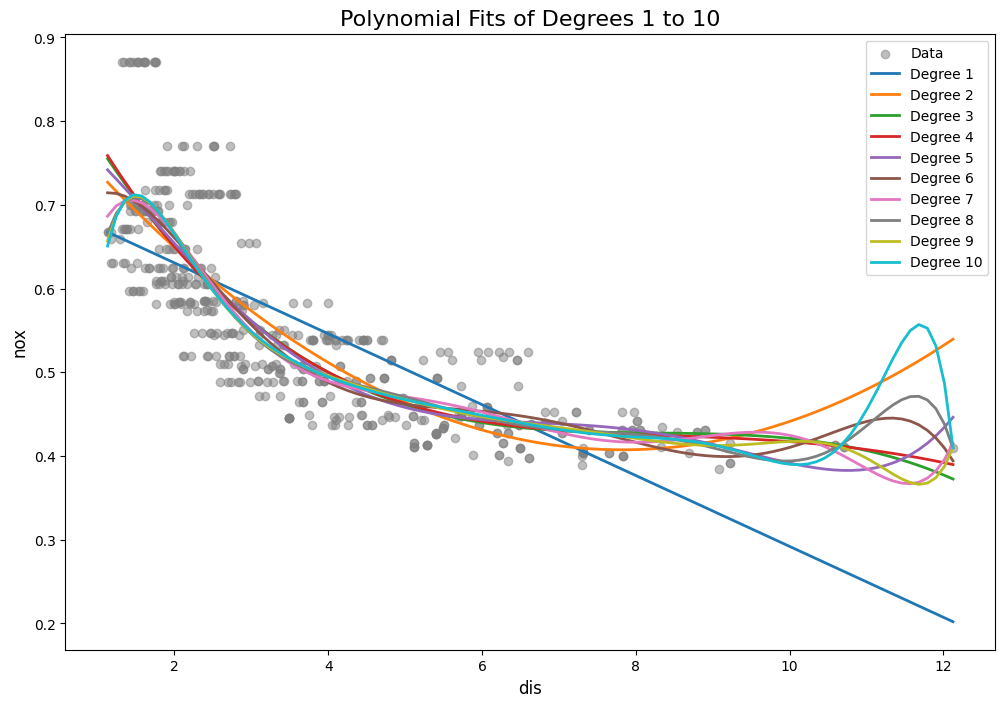

In [28]:
results = {}
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x.values.reshape(-1, 1))
    Xnew_poly = poly.transform(x_df.values)
    
    M = sm.OLS(y, sm.add_constant(X_poly)).fit()
    
    results[degree] = M.predict(sm.add_constant(Xnew_poly))

plt.figure(figsize=(12, 8))
plt.scatter(x, y, facecolor='gray', alpha=0.5, label='Data')

for degree, preds in results.items():
    plt.plot(x_df['dis'], preds, label=f'Degree {degree}', linewidth=2)

plt.title('Polynomial Fits of Degrees 1 to 10', fontsize=16)
plt.xlabel('dis', fontsize=12)
plt.ylabel('nox', fontsize=12)
plt.legend()
plt.show()

(c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results

In [30]:
cv_error = np.zeros(11)
H = np.array(x)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=5,shuffle=True,random_state=0)
for i, d in enumerate(range(1,12)):
    Xcross = np.power.outer(H, np.arange(d+1))
    Mat_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[i] = np.mean(Mat_CV['test_score'])
print(cv_error)

[0.00550455 0.00404589 0.00384482 0.00385288 0.00405327 0.00490166
 0.00711742 0.00654051 0.02188359 0.00468514 0.05257745]


Since the third 0.00384482 is the smallest one, we should select 3 degree for the polynomial.

(d) Use the bs() function from the ISLP.models module to ft a regression spline to predict nox using dis. Report the output for
the ft using four degrees of freedom. How did you choose the
knots? Plot the resulting ft.

In [36]:
bs_dis = MS([bs('dis', df=4)]).fit(data)
M_bs = sm.OLS(y, bs_dis.transform(data)).fit()
print(summarize(M_bs))
print("knots: ",BSpline(df=6).fit(x).internal_knots_)

                    coef  std err       t  P>|t|
intercept         0.7345    0.015  50.306  0.000
bs(dis, df=4)[0] -0.0581    0.022  -2.658  0.008
bs(dis, df=4)[1] -0.4636    0.024 -19.596  0.000
bs(dis, df=4)[2] -0.1998    0.043  -4.634  0.000
bs(dis, df=4)[3] -0.3888    0.046  -8.544  0.000
knots:  [2.100175 3.20745  5.188425]


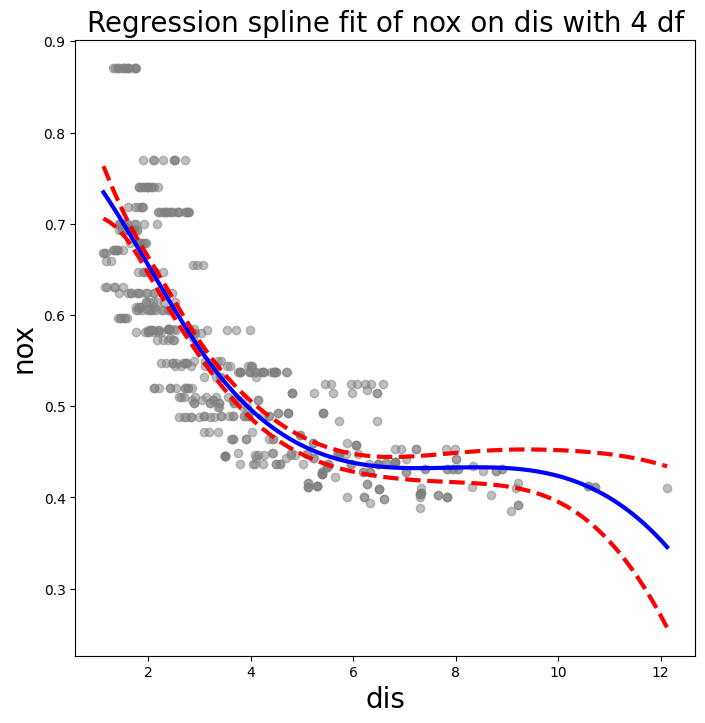

In [37]:

X = bs_dis.transform(data)
Xnew = bs_dis.transform(x_df)
M = sm.OLS(y, X).fit()
preds = M.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)
fig, ax = subplots(figsize=(8,8))
ax.scatter(x,y,facecolor='gray',alpha=0.5)
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(x_df.values, val, ls, linewidth=3)
ax.set_title('Regression spline fit of nox on dis with 4 df', fontsize=20)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20);

(e) Now ft a regression spline for a range of degrees of freedom, and
plot the resulting fts and report the resulting RSS. Describe the
results obtained

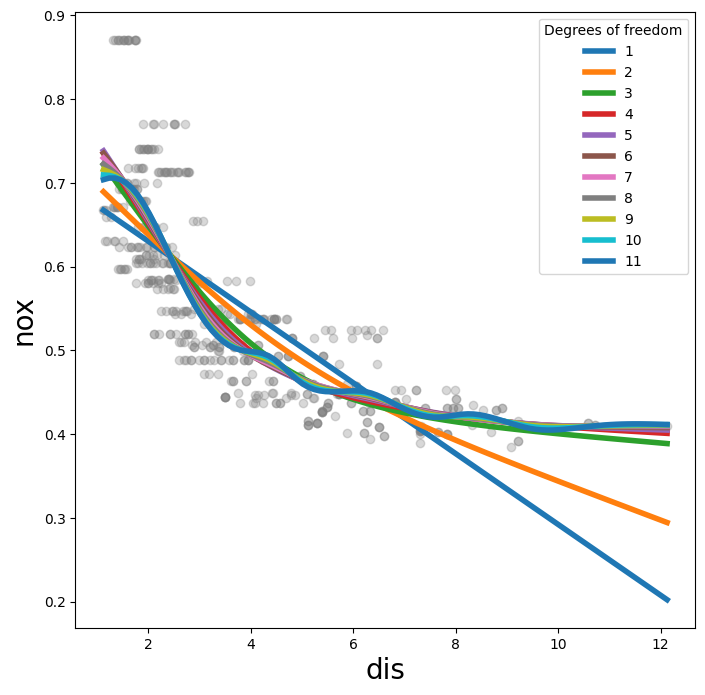

In [47]:
X_dis = np.asarray(x).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_dis, y)
age_term = gam.terms[0]
fig, ax = subplots(figsize=(8,8))
ax.scatter(x,
           y,
           facecolor='gray',
           alpha=0.3)
for df in range(1,12):
    lam = approx_lam(X_dis, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_dis, y)
    ax.plot(x_grid,
            gam.predict(x_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20);
ax.legend(title='Degrees of freedom');

(f) Perform cross-validation or another approach in order to select
the best degrees of freedom for a regression spline on this data.
Describe your results.


In [46]:
cv_error = np.zeros(9)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=10,shuffle=True,random_state=1)
for d in range(3,12):
    bs_dis = MS([bs('dis', df=d)]).fit(data)
    Xcross = bs_dis.transform(data)
    Mat_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[d-3] = np.mean(Mat_CV['test_score'])
cv_error

array([0.00387002, 0.00388453, 0.0037093 , 0.0037177 , 0.00372454,
       0.00371579, 0.00375893, 0.00371381, 0.00373558])

The optimal model is obtained for 5 degrees of freedom when the error is 0.0037093.